In [1]:
# Import required modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use ggplot
matplotlib.style.use('ggplot')

features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Load original dataset that was used to generate samples
df_original = pd.read_csv('../1_sample_preparation/source/d_clean_remove_small_samples.csv')
# Make sure required features are numeric
df_original[numeric_features] = df_original[numeric_features].astype(float)
df_original.reset_index(drop=True,inplace=True)

# Load synthetic data set
df_synthetic = pd.read_csv('../4_response_extraction/synthetic_data_rows.csv')
# Drop column
df_synthetic.drop(columns=['Unnamed: 0'],inplace=True)
# Make sure required features are numeric
df_synthetic[numeric_features] = df_synthetic[numeric_features].astype(float)
df_synthetic.reset_index(drop=True,inplace=True)

# Create a copy of the original DataFrame
df_synth_raw = df_synthetic.copy()

# Function to remove outliers for a specific feature
def remove_outliers(df, feature, lower_percentile, upper_percentile):
    Q1 = df[feature].quantile(lower_percentile)
    Q3 = df[feature].quantile(upper_percentile)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for all numeric features
for nf in numeric_features:
    df_synth_raw = remove_outliers(df_synth_raw, nf, 0.005, 0.995)


print(f"Original DataFrame length: {len(df_synthetic)}")
print(f"DataFrame length after removing outliers 'RAW' for Inf values: {len(df_synth_raw)} - Rows lost: {len(df_synthetic) - len(df_synth_raw)}")

# print("\ndf_original head:",df_original.head())
# print("\ndf_original info:",df_original.info())
# print("\ndf_original unique prompt_method: NA")
# print("\ndf_original unique prompt_short: NA")
# print("\ndf_original unique sample_size: NA")
# print("\ndf_original unique target_material:",df_original['target_material'].unique())
# print("\ndf_original unique model: NA")

# print("\ndf_synth_raw head:",df_synth_raw.head())
# print("\ndf_synth_raw info:",df_synth_raw.info())
# print("\ndf_synth_raw unique prompt_method:",df_synth_raw['prompt_method'].unique())
# print("\ndf_synth_raw unique prompt_short:",df_synth_raw['prompt_short'].unique())
# print("\ndf_synth_raw unique sample_size:",df_synth_raw['sample_size'].unique())
# print("\ndf_synth_raw unique target_material:",df_synth_raw['target_material'].unique())
print("\ndf_synth_raw unique model:",df_synth_raw['model'].unique())

# df_synth_raw.groupby(['model','prompt_method','sample_size']).count()

Original DataFrame length: 163300
DataFrame length after removing outliers 'RAW' for Inf values: 159860 - Rows lost: 3440

df_synth_raw unique model: ['claude-3-5-sonnet-20240620' 'claude-3-sonnet-20240229' 'gemma:7b'
 'gpt-3.5-turbo-0125' 'gpt-4o' 'llama2:13b' 'llama3:8b' 'llama3:70b'
 'mistral:7b' 'mixtral:8x22b' 'phi3:medium-128k' 'phi3:mini-128k']


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Define features and target
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power']
target = 'cutoff_energy'

def clip_r2(r2):
    return max(0, r2)

def prepare_data(df, features, target, test_size=0.2, val_size=0.2):
    X = df[features]
    y = df[target]
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

def create_neural_network(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

def train_and_evaluate_models(X_train, y_train, X_val, y_val, X_test, y_test, models):
    results = []
    
    for name, model in models.items():
        if name == 'Neural Network':
            model = create_neural_network(X_train.shape[1])
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        else:
            model.fit(X_train, y_train)
        
        # Train-test results
        y_pred_test = model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = clip_r2(r2_score(y_test, y_pred_test))
        
        # Validation results
        y_pred_val = model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        r2_val = clip_r2(r2_score(y_val, y_pred_val))
        
        results.append({
            'ml_model': name,
            'Average RMSE': rmse_test,
            'Average R2': r2_test,
            'Eval RMSE': rmse_val,
            'Eval R2': r2_val
        })
    
    return pd.DataFrame(results)    

# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=500, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Neural Network': None  # We'll create this for each fold
}

# Prepare original data
X_train_orig, X_val_orig, X_test_orig, y_train_orig, y_val_orig, y_test_orig, scaler_orig = prepare_data(df_original, features, target)

# Train and evaluate models on original data
print("Original Data Model Results:")
results_orig = train_and_evaluate_models(X_train_orig, y_train_orig, X_val_orig, y_val_orig, X_test_orig, y_test_orig, models)

# Rename columns for original results
results_orig = results_orig.rename(columns={
    'Average RMSE': 'ORI-Test RMSE',
    'Average R2': 'ORI-Test R2',
    'Eval RMSE': 'ORI-Validate RMSE',
    'Eval R2': 'ORI-Validate R2'
})

# Dictionary to store results for each synthetic model
all_results = {'Original': results_orig}

# Train and evaluate models for each unique synthetic model
for use_model in df_synth_raw['model'].unique():
    print(f"\nSynthetic Data Model Results for {use_model}:")
    df_synthetic = df_synth_raw[df_synth_raw['model'] == use_model]
    X_train_synth, X_val_synth, X_test_synth, y_train_synth, y_val_synth, y_test_synth, scaler_synth = prepare_data(df_synthetic, features, target)
    
    results_synth = train_and_evaluate_models(X_train_synth, y_train_synth, X_val_orig, y_val_orig, X_test_synth, y_test_synth, models)
    
    # In the loop for synthetic models:
    results_synth = results_synth.rename(columns={
        'Average RMSE': f'{use_model}-Test RMSE',
        'Average R2': f'{use_model}-Test R2',
        'Eval RMSE': f'{use_model}-Validate-ORI RMSE',
        'Eval R2': f'{use_model}-Validate-ORI R2'
    })
    
    # Evaluate synthetic models on original test set
    eval_results = []
    for name, model in models.items():
        if name == 'Neural Network':
            model = create_neural_network(X_train_synth.shape[1])
            model.fit(X_train_synth, y_train_synth, epochs=100, batch_size=32, verbose=0)
        else:
            model.fit(X_train_synth, y_train_synth)
        
        y_pred_synth = model.predict(X_test_orig)
        rmse_synth = np.sqrt(mean_squared_error(y_test_orig, y_pred_synth))
        r2_synth = clip_r2(r2_score(y_test_orig, y_pred_synth))
        eval_results.append({
            'ml_model': name,
            f'{use_model}-Test-ORI RMSE': rmse_synth,
            f'{use_model}-Test-ORI R2': r2_synth
        })
    
    eval_df = pd.DataFrame(eval_results)
    results_synth = pd.merge(results_synth, eval_df, on='ml_model', how='outer')
    
    all_results[use_model] = results_synth

# Combine all results
final_results = results_orig
for model, results in all_results.items():
    if model != 'Original':
        final_results = pd.merge(final_results, results, on='ml_model', how='outer')

# Remove duplicate columns
final_results = final_results.loc[:, ~final_results.columns.duplicated()]

print("\nFinal Results:")
print(final_results)

2024-07-06 15:04:49.390510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 15:04:49.404155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 15:04:49.404188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 15:04:49.415364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 15:04:50.142043: W tensorflow/compiler/tf

Original Data Model Results:


2024-07-06 15:04:51.720462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 15:04:51.751978: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

Synthetic Data Model Results for claude-3-5-sonnet-20240620:
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Synthetic Data Model Results for claude-3-sonnet-20240229:
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Synthetic Data Model Results for gemma:7b:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Synthetic Data Model Results for gpt-3.5-turbo-0125:
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Synthetic Data Model Results for gpt-4o:
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Synthetic Data Model Results for llama2:13b:
21/21 ━━━━━━━━━━━━━━

In [5]:
final_results

,ml_model,ORI-Test RMSE,ORI-Test R2,ORI-Validate RMSE,ORI-Validate R2,claude-3-5-sonnet-20240620-Test RMSE,claude-3-5-sonnet-20240620-Test R2,claude-3-5-sonnet-20240620-Validate-ORI RMSE,claude-3-5-sonnet-20240620-Validate-ORI R2,claude-3-5-sonnet-20240620-Test-ORI RMSE,...,phi3:medium-128k-Validate-ORI RMSE,phi3:medium-128k-Validate-ORI R2,phi3:medium-128k-Test-ORI RMSE,phi3:medium-128k-Test-ORI R2,phi3:mini-128k-Test RMSE,phi3:mini-128k-Test R2,phi3:mini-128k-Validate-ORI RMSE,phi3:mini-128k-Validate-ORI R2,phi3:mini-128k-Test-ORI RMSE,phi3:mini-128k-Test-ORI R2
0,Neural Network,7.481998,0.595505,11.154075,0.093121,4.931729,0.921063,9.205952,0.382240,9.694119,...,22.976354,-2.848085,23.660239,-3.044979,9.778355,-0.915754,13.893797,-0.407098,14.130287,-0.442713
1,Random Forest,3.614532,0.905598,2.875984,0.939709,3.883830,0.951044,8.937115,0.417793,8.417566,...,19.271285,-1.707097,19.783708,-1.828091,5.218361,0.454398,5.618473,0.769899,6.115833,0.729735
2,SVR,6.717601,0.673933,5.919862,0.744550,6.263225,0.872685,6.524898,0.689666,7.136499,...,11.436516,0.046611,10.972439,0.130070,6.998454,0.018676,11.523270,0.032092,11.691647,0.012290


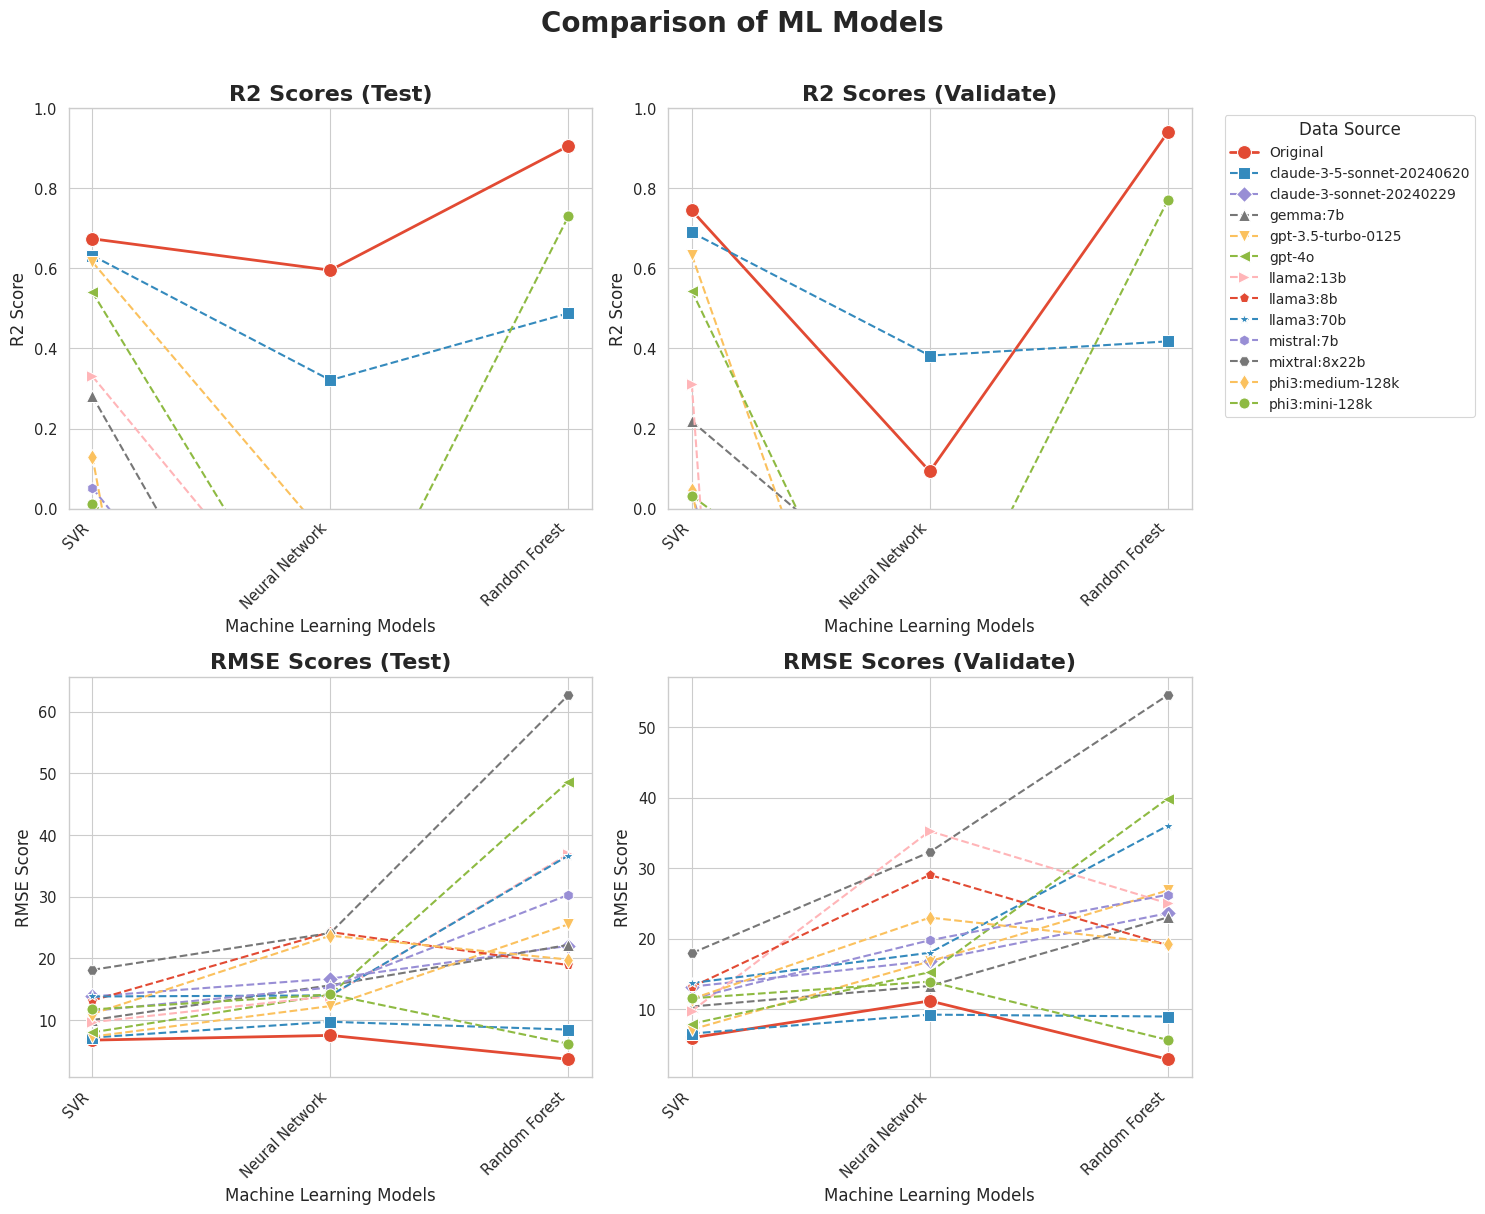

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_results(final_results):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    metrics = ['R2', 'RMSE']
    score_types = ['Test', 'Validate']
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'd']
    
    # Define the desired order of ML models
    ml_model_order = ['SVR', 'Neural Network', 'Random Forest']
    
    # Ensure the data is sorted according to the desired order
    final_results['ml_model'] = pd.Categorical(final_results['ml_model'], categories=ml_model_order, ordered=True)
    final_results = final_results.sort_values('ml_model')
    
    for i, metric in enumerate(metrics):
        for j, score_type in enumerate(score_types):
            ax = axs[i, j]
            for k, model in enumerate(all_results.keys()):
                if model == 'Original':
                    sns.lineplot(x='ml_model', y=f'ORI-{score_type} {metric}', data=final_results, 
                                 marker=markers[k], markersize=10, linewidth=2, label='Original', ax=ax)
                else:
                    sns.lineplot(x='ml_model', y=f'{model}-{score_type}-ORI {metric}', data=final_results, 
                                 marker=markers[k % len(markers)], markersize=8, linewidth=1.5, 
                                 linestyle='--', label=model, ax=ax)
            
            ax.set_title(f'{metric} Scores ({score_type})', fontsize=16, fontweight='bold')
            ax.set_xlabel('Machine Learning Models', fontsize=12)
            ax.set_ylabel(f'{metric} Score', fontsize=12)
            
            # Set x-axis ticks and labels
            ax.set_xticks(range(len(ml_model_order)))
            ax.set_xticklabels(ml_model_order, rotation=45, ha='right')
            
            if metric == 'R2':
                ax.set_ylim(0, 1)
            
            if i == 0 and j == 1:  # Only show legend for the top-right subplot
                ax.legend(fontsize=10, title='Data Source', title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                ax.get_legend().remove()

    plt.suptitle('Comparison of ML Models', fontsize=20, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('ML_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate the plot
plot_all_results(final_results)